In [40]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,4)
import matplotlib.image as mpimg
import numpy as np
import os
import glob
import cv2
%matplotlib notebook

In [54]:
# Change this to the directory where you store KITTI data
basedir = '../data_stereo_flow/training/'
image_index = '000005_10'
l_ifile = basedir+'image_0/'+image_index+'.png'
r_ifile = basedir+'image_1/'+image_index+'.png'
disp_file = basedir+'disp_noc/'+image_index+'.png'
imL = cv2.imread(l_ifile,0)
imR = cv2.imread(r_ifile,0)
disp_gt = cv2.imread(disp_file,0)


<IPython.core.display.Javascript object>


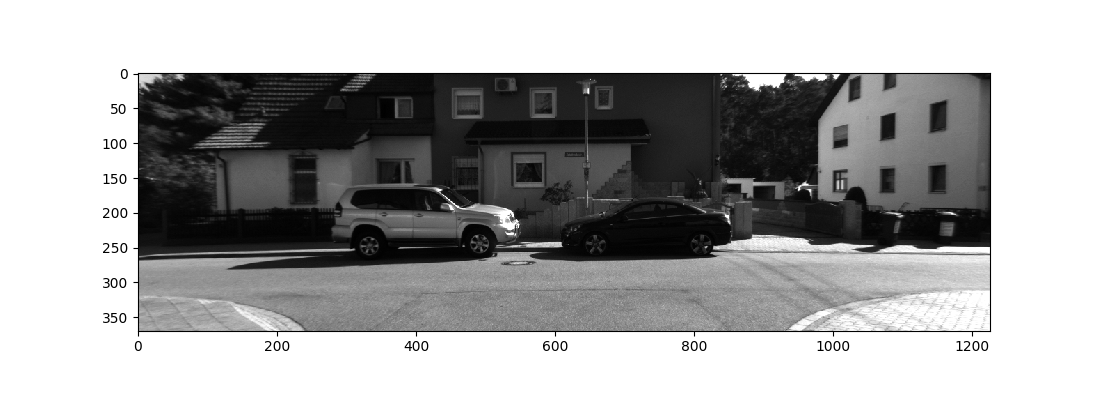

In [74]:

min_disp=0
num_disp=1600
#stereo = cv2.createStereoBM(numDisparities=16, blockSize=15)
stereo = cv2.StereoSGBM_create(minDisparity = min_disp, numDisparities=num_disp, blockSize=15)
disp = stereo.compute(imL,imR).astype(np.float32)/16 # 4 fractional bits 
#plt.show()
#pts = plt.ginput(3)
#print pts
plt.figure()
plt.imshow(imL,cmap='gray')



<IPython.core.display.Javascript object>


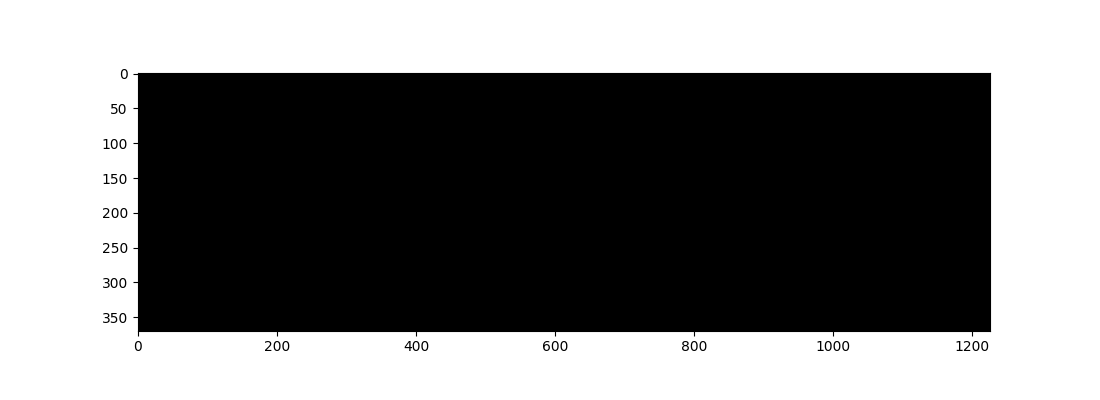

In [75]:
plt.figure()
plt.imshow(disp.astype(int),cmap = 'gray')

In [59]:
387/disp_gt[150,646]

16.125

In [69]:
disp[150,646]/16

1.55078125